## Research Hypothesis

**Hypothesis:** We want to test if we can predict the location (specific location) of a tsunami based on several criteria, e.g:
- Date
- Earthquake Magnitude
- Country
- Water Height
- etc.

## Default imports

In [6]:
import os
import pandas as pd

# from bs4 import BeautifulSoup

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

## Crawling and fetching data from external website

We will configure webdriver (Selenium) with headless option to crawl to ```ngdc.noaa.gov``` and collect out relevant data.<br>
The website loades tables in a weird manner, it only renders the rows and columns that fit the screen (even in the code),<br>
so an alternative I picked was to click dynamically on a button that downloads a ```.tsv``` file locally.

We verify that there are no other ```.tsv``` files in the local directory and if there are we remove them and then downloading the update file.

In [7]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')

# Max = 2022, Min = 1992 (Last 30 years)
crawl_url = "https://www.ngdc.noaa.gov/hazel/view/hazards/tsunami/event-data?maxYear=2022&minYear=1992"

browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)
try:
  files = os.scandir('./')
  for file in files:
    if file.is_file() and file.name.endswith('.tsv'):
      os.remove(file)

  browser.get(crawl_url)
  timeout = 20
  WebDriverWait(browser, timeout).until(ec.presence_of_element_located((By.CLASS_NAME, 'haz-grid')))
  button = browser.find_element(by=By.CLASS_NAME, value='fa-file-download')
  button.click()
except TimeoutException:
  print("Can't handle...")

# Couldn't make if to work because of the explanation above:

# titles = []
# data = []

# crawl_soup = BeautifulSoup(browser.page_source, 'html.parser')
# soup_rows = crawl_soup.find('div', {'class': 'haz-grid'})
# children = soup_rows.findAll('div', recursive=False)
# inner = children[1].find('div', recursive=False)
# sec_inner = inner.findAll('div', recursive=False)
# soup_column_names_e = sec_inner[0].find('div', recurise=False)
# soup_column_names_e2 = soup_column_names_e[0].find('div', recurise=False)
# soup_column_names_div = soup_column_names_e2.find('div', recurise=False)
# soup_data_rows = sec_inner[1]

# for div in soup_column_names_div:
#   inner_div = div.find('div', recursive=False)
#   second_div = inner_div.find('div', recursive=False)
#   titles.append(second_div.text)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/orrgoren/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
/var/folders/27/lh1n32415qgg2sysk9tssv580000gq/T/ipykernel_30191/554252747.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)


## Create the DataFrame

I'm validating that we have a local ```.tsv``` file and we convert it to a DataFrame.<br>
I remove the first row and first column that are useless to our data.<br>
I save an instance of the original DataFrame so I can use it later.

In [8]:
f_name = ''
path = './'
obj = os.scandir(path);

for entry in obj:
  if entry.is_file() and entry.name.endswith('.tsv'):
    f_name = entry.name

df = pd.read_csv(f_name, delimiter="\t")
df = df.iloc[: , 1:] # Remove first column
df = df.iloc[1: , :] # Remove first row

original_df = df.copy()

## Cleaning The Data recieved

I'm dropping the useless columns, those with a lot of null values or duplicate data, for example:<br>
Total Death and Death are equal with their values.<br>
I stated that I want columns with atleast 400 values inside and not less.

In [9]:
to_drop = ['Vol',
          'More Info',
          'Deposits',
          'Number of Runups',
          'Tsunami Magnitude (Abe)',
          'Tsunami Magnitude (Iida)',
          'Tsunami Intensity',
          'Houses Destroyed Description',
          'Damage Description',
          'Injuries Description',
          'Missing Description',
          'Location Name',
          'Death Description',
          'Total Death Description',
          'Total Missing Description',
          'Total Injuries Description',
          'Total Damage Description',
          'Total Houses Destroyed Description',
          'Total Houses Damaged Description',
          'Houses Damaged Description',
          'Damage ($Mil)',
          'Deaths',
          'Missing',
          'Injuries',
          'Houses Destroyed',
          'Houses Damaged',
          'Total Missing',
          'Total Damage ($Mil)',
          'Total Houses Destroyed',
          'Total Houses Damaged']

# Drop not relevant columns
df.drop(to_drop, inplace=True, axis=0, errors='ignore')
# Drop duplicate rows
df.drop_duplicates()
# Remove nulls and Fill 0
df.dropna(axis=1, thresh=300, inplace=True)
df.fillna(0, inplace=True)

## EDA

The first chart is showing us the number of tsunami's divided by the countries.

#### Country vs. Tsunami

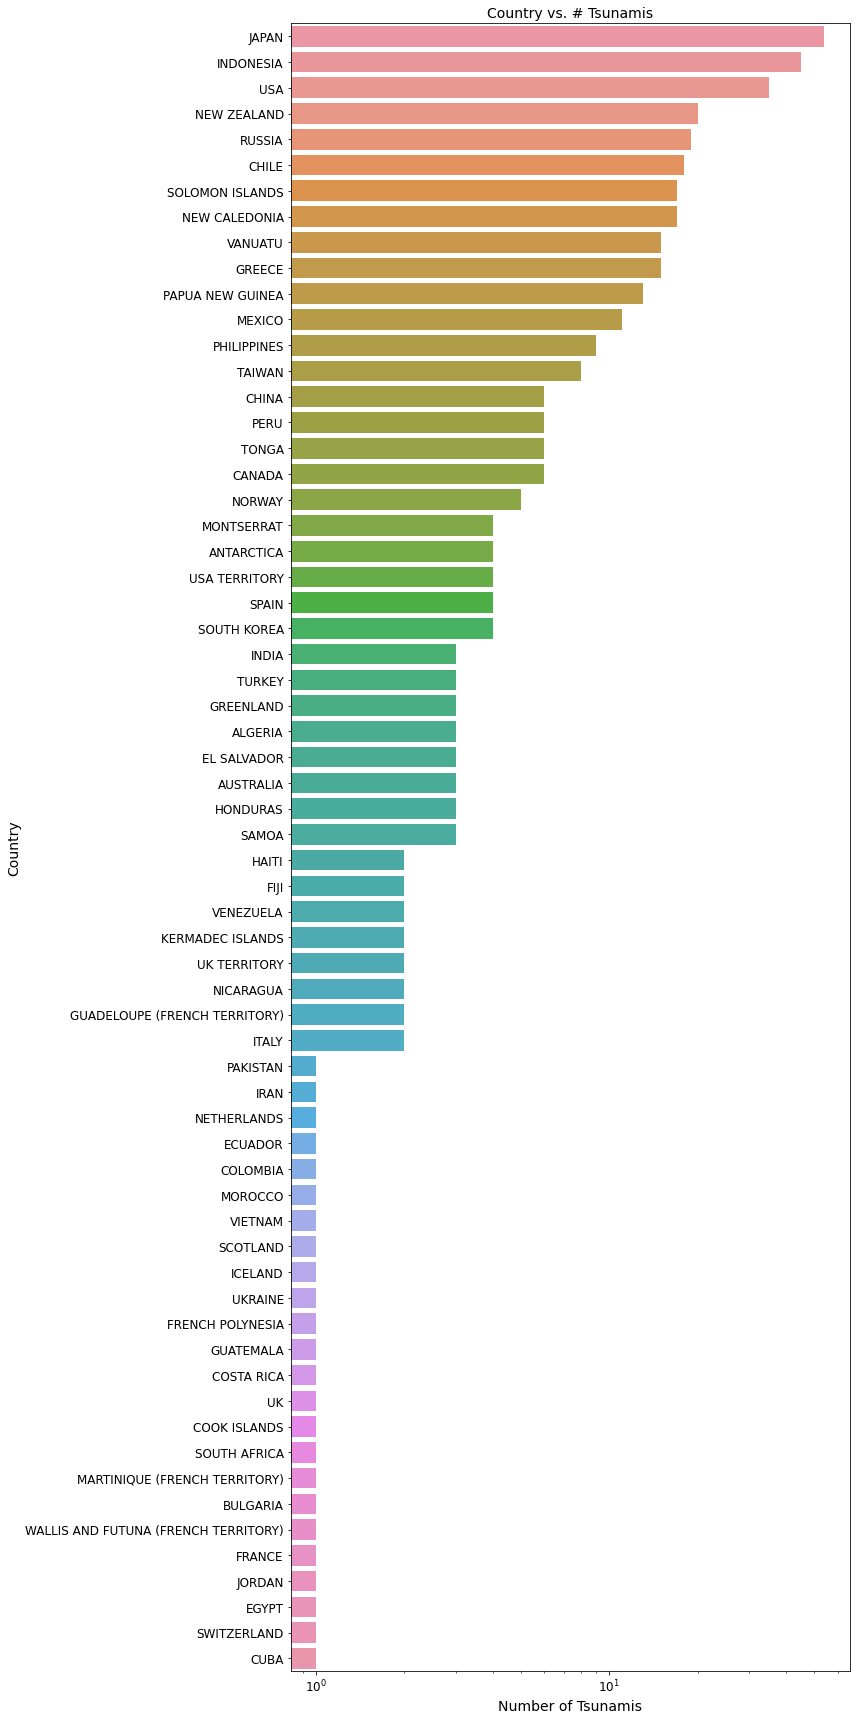

In [10]:
plt.figure(figsize=(12,24))
countries = df["Country"].value_counts().keys().tolist()
ax = sns.countplot(y="Country", data = df, order = df["Country"].value_counts().index)
ax.set_xscale("log")
ax.axes.set_title("Country vs. # Tsunamis", fontsize = 14)
ax.set_xlabel("Number of Tsunamis", fontsize = 14)
ax.set_ylabel("Country", fontsize = 14)
ax.tick_params(labelsize = 12)
ax.set_yticklabels(countries, rotation = 0, fontsize = 12)
plt.tight_layout()
plt.show()

### Earthquake Magnitude vs. Tsunami

The following chart is showing us the # of tsunami's vs the earthquake magnitude.

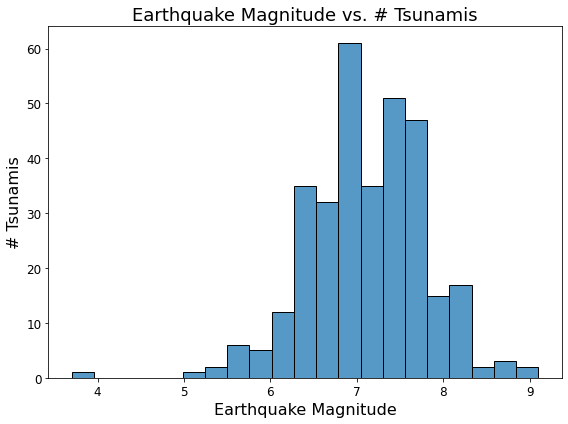

In [11]:
plt.figure(figsize=(8,6))
ax = sns.histplot(original_df["Earthquake Magnitude"], kde = False)
ax.axes.set_title("Earthquake Magnitude vs. # Tsunamis", fontsize=18)
ax.set_xlabel("Earthquake Magnitude", fontsize=16)
ax.set_ylabel("# Tsunamis", fontsize=16)
ax.tick_params(labelsize = 12)
plt.tight_layout()
plt.show()

## Advanced Data Analysis

I chose the KNN Algorithm because we are dealing with a classification problem, **regression** to be exact.

### KNN

In [13]:
df['CountryNew'] = preprocessing.LabelEncoder().fit_transform(df.Country)
df['Location Name'] = preprocessing.LabelEncoder().fit_transform(df['Location Name'])

X = df.loc[:, ~df.columns.isin(['Country', 'Location Name'])]
y = df['Country']

XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)

k = 5
clf = KNeighborsClassifier(n_neighbors = k)
clf.fit(XTrain, yTrain)
y_pred = clf.predict(XTest)

### Confusion Matrix

In [14]:
metrics.confusion_matrix(y_true = yTest, y_pred = y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 3]])

### Prediction Accuracy

In [15]:
acc = metrics.accuracy_score(y_true = yTest, y_pred = y_pred)
print(f'Accuracy is: {round(acc*100, 0)}%')

Accuracy is: 54.0%


### Multiple K's Testing

We will run from ```K = 3``` until ```K = 25``` to test multiple answers and find the best ```K``` to use.

In [16]:
k_list = []
train_accuracies = []
test_accuracies = []
for k in range(3, 25):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(XTrain, yTrain)
    y_pred_train = clf.predict(XTrain)
    y_pred = clf.predict(XTest)
    k_list.append(k)
    train_accuracies.append(metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
    test_accuracies.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

df_k = pd.DataFrame({ "k": k_list, "train_accuracy": train_accuracies, "test_accuracy": test_accuracies })
df_k

,k,train_accuracy,test_accuracy
0,3,0.810398,0.500000
1,4,0.752294,0.536585
2,5,0.727829,0.536585
3,6,0.730887,0.524390
4,7,0.694190,0.536585
5,8,0.669725,0.512195
6,9,0.642202,0.500000
7,10,0.626911,0.487805
8,11,0.636086,0.512195
9,12,0.623853,0.512195


Taking in account we only take odd KNN's, we can see that the best K for the test is = **5**.

### Conclusion

As seen above, the best accuracy percent is ```54%```.<br>
Altough this is more than 50%, percentage below ```80% - 85%``` is found ineffective in determing an accurate distinction.<br>

According to all of the data that been gathered and the test made, we still don't have enough information to distinct a specific location by those criteria.